In [16]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Conv2D, Activation, BatchNormalization,
    UpSampling2D, Input, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters

In [18]:
IMAGE_SIZE = 256
EPOCHS = 10
BATCH_SIZE = 8
LR = 1e-4

PATH = "."

# Dataset

In [19]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    total_size = len(images)
    valid_size = int(total_size * split)
    test_size = int(total_size * split)
    
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)
    
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [20]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    
    return x

## Building the tf.data pipeline

In [21]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    
    return x, y


def tf_dataset(x, y, batch=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    
    return dataset

In [22]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  122
Validation data:  15
Testing data:  15


In [23]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    
    return x

# Model

In [24]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [25]:
model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 16)         432       ['input_image[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 16)         64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 16)         0         ['bn_Conv1[0][0]']      

# Metrics

In [26]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Training

In [27]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH_SIZE)

In [28]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [29]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [30]:
train_steps = len(train_x) // BATCH_SIZE
valid_steps = len(valid_x) // BATCH_SIZE

if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1
if len(valid_x) % BATCH_SIZE != 0:
    valid_steps += 1
    
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/10


2024-01-28 18:03:43.005357: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6fdd3d22a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 18:03:43.005390: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce 920MX, Compute Capability 5.0
2024-01-28 18:03:43.024834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706475823.242715  458641 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - 138s 3s/step - loss: 0.9638 - dice_coef: 0.0360 - recall_1: 0.8647 - precision_1: 0.0305 - val_loss: 0.9593 - val_dice_coef: 0.0411 - val_recall_1: 0.9424 - val_precision_1: 0.0643 - lr: 1.0000e-04
Epoch 2/10
16/16 [==============================] - 21s 1s/step - loss: 0.9498 - dice_coef: 0.0496 - recall_1: 0.9943 - precision_1: 0.0480 - val_loss: 0.9590 - val_dice_coef: 0.0413 - val_recall_1: 0.9835 - val_precision_1: 0.0233 - lr: 1.0000e-04
Epoch 3/10
16/16 [==============================] - 21s 1s/step - loss: 0.9443 - dice_coef: 0.0550 - recall_1: 0.9995 - precision_1: 0.0532 - val_loss: 0.9555 - val_dice_coef: 0.0449 - val_recall_1: 0.9856 - val_precision_1: 0.0402 - lr: 1.0000e-04
Epoch 4/10
16/16 [==============================] - 21s 1s/step - loss: 0.9406 - dice_coef: 0.0587 - recall_1: 0.9999 - precision_1: 0.0584 - val_loss: 0.9536 - val_dice_coef: 0.0468 - val_recall_1: 0.9669 - val_precision_1: 0.0771 - lr: 1.0000e-04
Epoch 5/10
16/

In [31]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH_SIZE)

test_steps = len(test_x) // BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
model.evaluate(test_dataset, steps=test_steps)

2/2 [==============================] - 1s 379ms/step - loss: 0.9752 - dice_coef: 0.0251 - recall_1: 0.0086 - precision_1: 0.0162


[0.9752210378646851,
 0.025111880153417587,
 0.008573528379201889,
 0.01624883897602558]

# Results

In [32]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [33]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 23ms/step


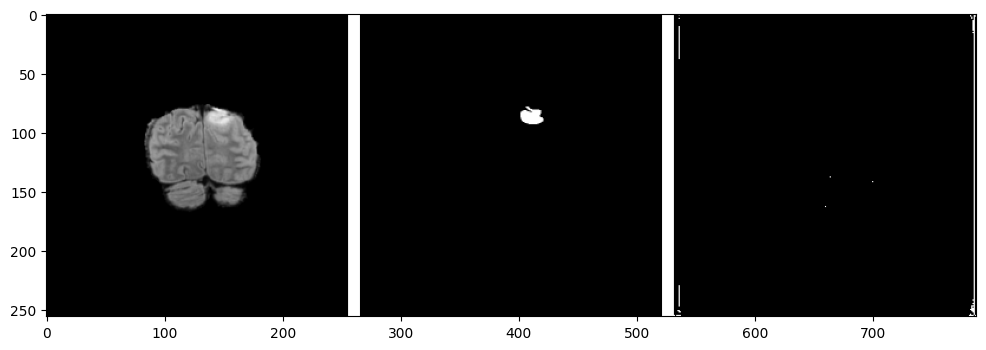

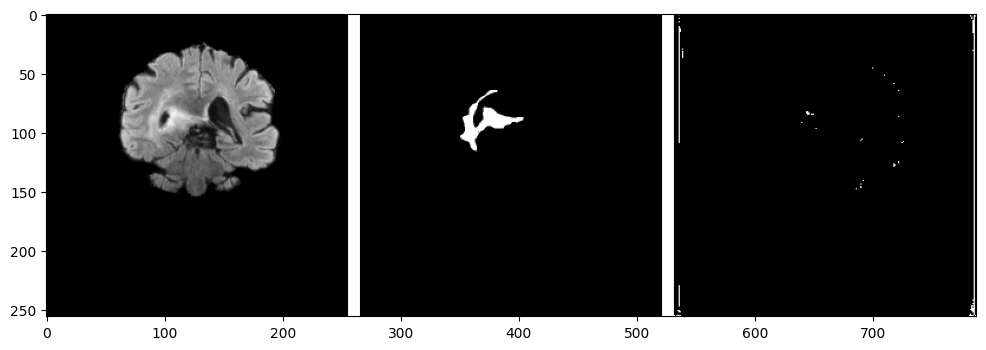

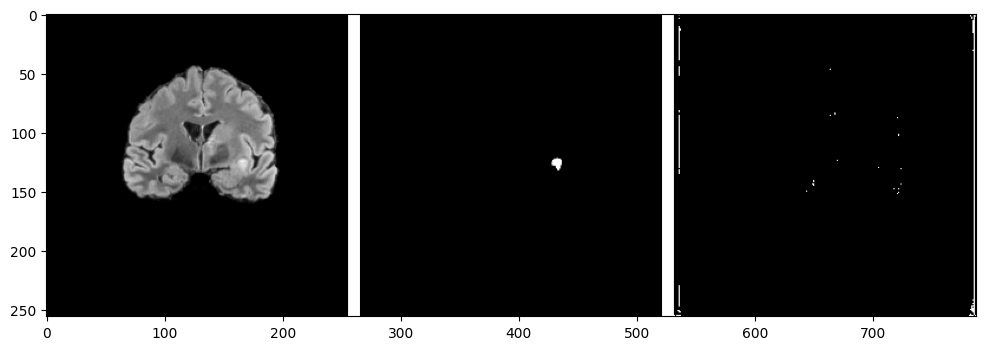

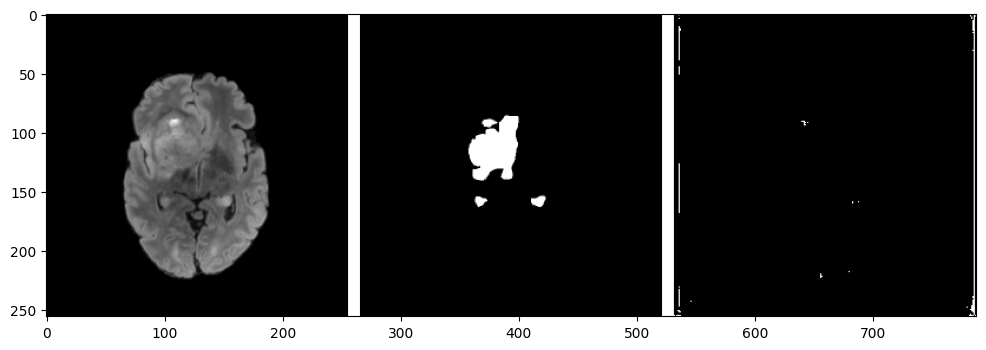

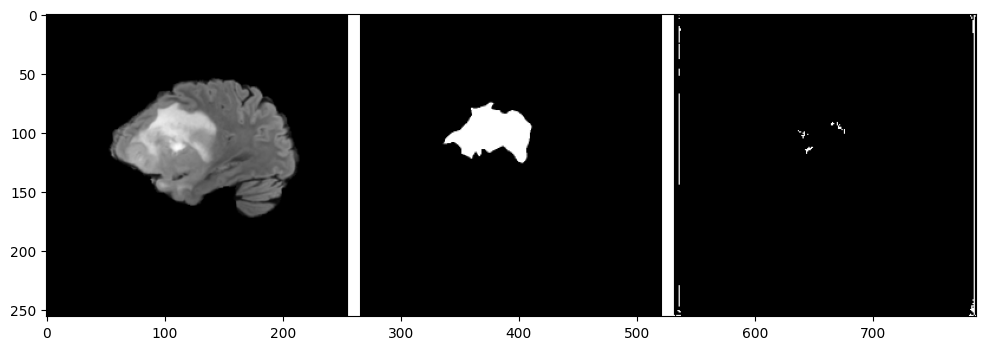

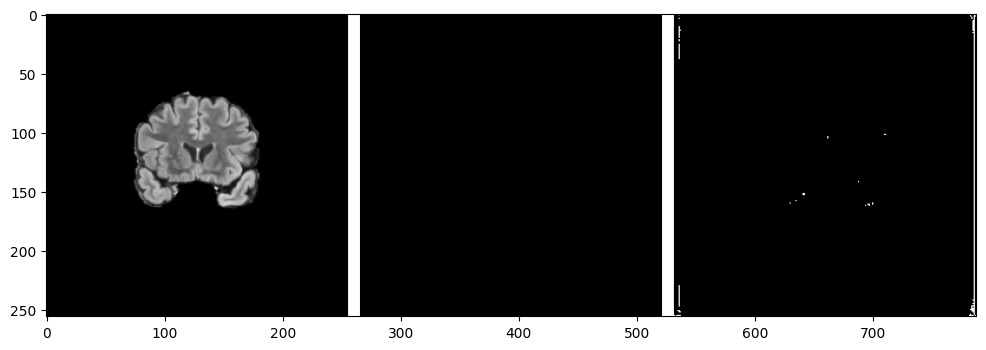

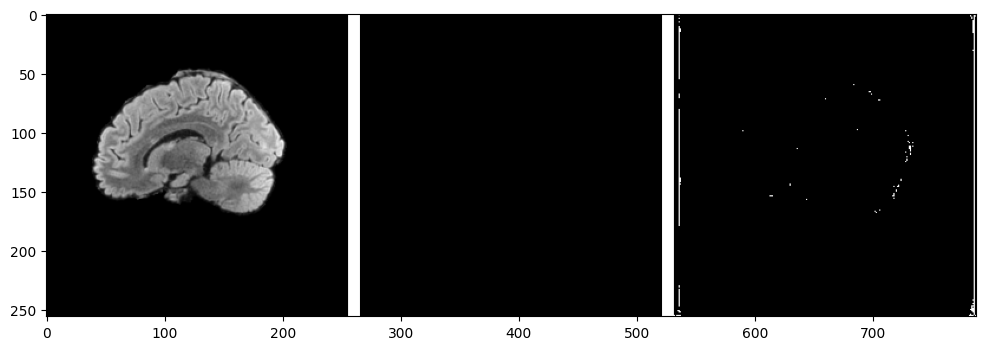

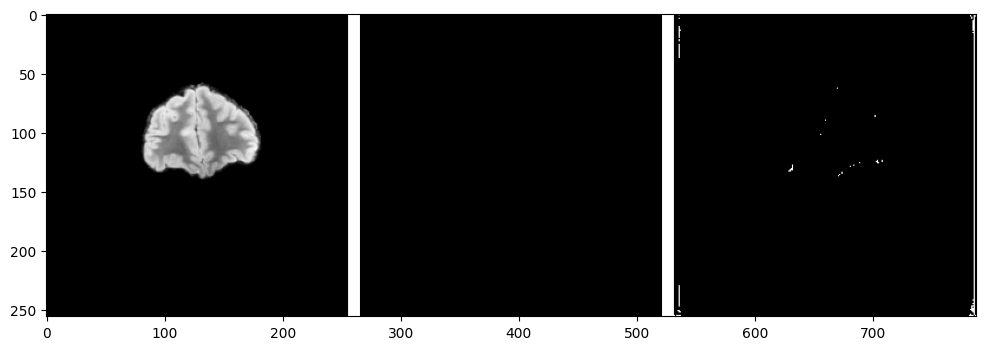

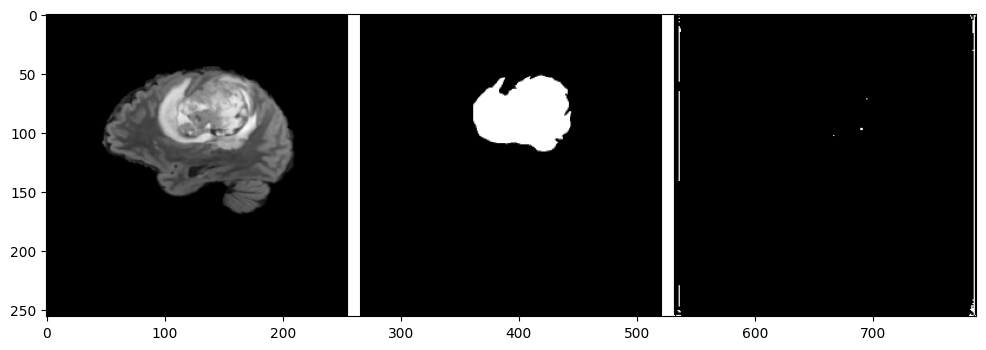

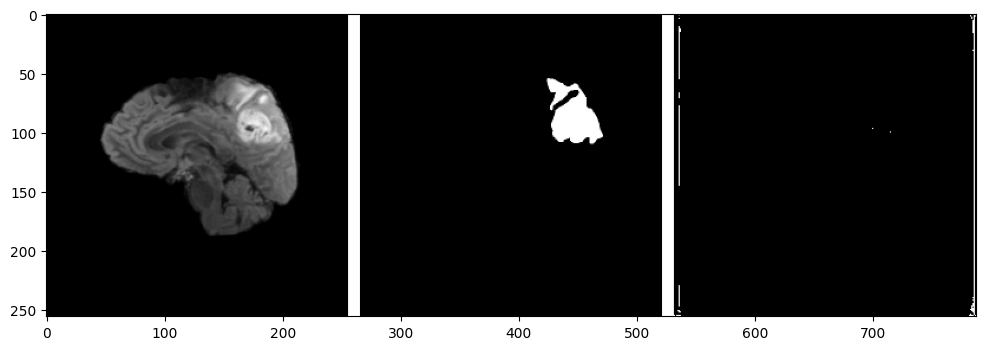

In [34]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)